In [ ]:
!cp "/content/drive/MyDrive/AI_SpillGuard/dataset.zip" /content/

In [ ]:
!unzip -q /content/dataset.zip -d /content/dataset

In [ ]:
# (optional) uncomment if albumentations needed:
# !pip install -q albumentations==1.2.1

import os, random
from glob import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

# For reproducibility (optional)
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [ ]:
# update these to where your M1 unzipped dataset is
TRAIN_IMG_DIR = '/content/dataset/train/images'
TRAIN_MASK_DIR = '/content/dataset/train/masks'
VAL_IMG_DIR   = '/content/dataset/val/images'
VAL_MASK_DIR  = '/content/dataset/val/masks'
TEST_IMG_DIR  = '/content/dataset/test/images'
TEST_MASK_DIR = '/content/dataset/test/masks'

# quick existence check
for p in [TRAIN_IMG_DIR, TRAIN_MASK_DIR, VAL_IMG_DIR, VAL_MASK_DIR, TEST_IMG_DIR, TEST_MASK_DIR]:
    print(p, "exists?" , os.path.exists(p))


/content/dataset/train/images exists? True
/content/dataset/train/masks exists? True
/content/dataset/val/images exists? True
/content/dataset/val/masks exists? True
/content/dataset/test/images exists? True
/content/dataset/test/masks exists? True


In [ ]:
def make_pairs(img_dir, mask_dir):
    imgs = sorted(glob(os.path.join(img_dir, '*')))
    mask_map = { os.path.splitext(os.path.basename(p))[0]: p for p in sorted(glob(os.path.join(mask_dir,'*'))) }
    pairs = []
    for ip in imgs:
        key = os.path.splitext(os.path.basename(ip))[0]
        if key in mask_map:
            pairs.append((ip, mask_map[key]))
    return pairs

train_pairs = make_pairs(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
val_pairs   = make_pairs(VAL_IMG_DIR, VAL_MASK_DIR)
test_pairs  = make_pairs(TEST_IMG_DIR, TEST_MASK_DIR)

print("Train:", len(train_pairs), "Val:", len(val_pairs), "Test:", len(test_pairs))
# Print 3 example pairs
print("Example pairs (3):", train_pairs[:3])


Train: 811 Val: 203 Test: 254
Example pairs (3): [('/content/dataset/train/images/Oil (1).jpg', '/content/dataset/train/masks/Oil (1).png'), ('/content/dataset/train/images/Oil (10).jpg', '/content/dataset/train/masks/Oil (10).png'), ('/content/dataset/train/images/Oil (100).jpg', '/content/dataset/train/masks/Oil (100).png')]


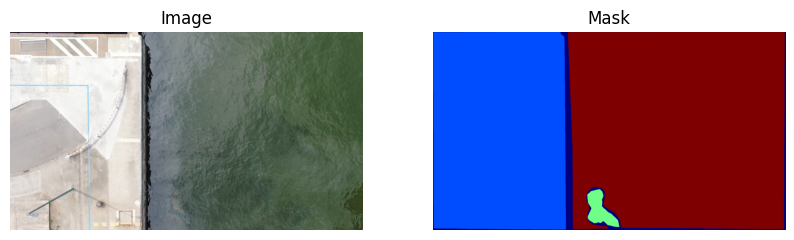

In [ ]:
def show_sample(pair):
    img_path, mask_path = pair
    img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    if mask is None:
        raise ValueError("Mask unreadable: "+mask_path)
    if mask.ndim == 3:
        display_mask = mask[:,:,0]
    else:
        display_mask = mask
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(img); plt.title('Image'); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(display_mask, cmap='jet'); plt.title('Mask'); plt.axis('off')
    plt.show()

show_sample(train_pairs[0])


In [ ]:
# Example: inspect unique colors in one mask to see if color-coded
sample_mask = cv2.imread(train_pairs[0][1])
print("mask shape:", sample_mask.shape)
# get up to 20 unique colors (RGB)
colors = np.unique(sample_mask.reshape(-1,3), axis=0)
print("Unique colors (count):", len(colors))
print(colors[:20])

# If you see more than a few distinct RGB colors and they match classes,
# create a color_map: {(R,G,B):label}
# Example:
# color_map = {(0,0,0):0, (0,255,0):1, (0,0,255):2}
# Adjust the color_map below to match your mask colors.

def convert_color_mask_to_labels(mask_rgb, color_map):
    h,w = mask_rgb.shape[:2]
    label_mask = np.zeros((h,w), dtype=np.uint8)
    for color, label in color_map.items():
        match = np.all(mask_rgb == np.array(color, dtype=np.uint8)[None,None,:], axis=-1)
        label_mask[match] = label
    return label_mask

# If you need this, fill color_map and test:
# color_map = {(R,G,B):label, ...}
# test = convert_color_mask_to_labels(sample_mask[:,:,::-1], color_map)  # OpenCV is BGR; convert accordingly
# plt.imshow(test, cmap='jet'); plt.show()


mask shape: (1080, 1920, 3)
Unique colors (count): 4
[[  0   0   0]
 [ 51 204 255]
 [124   0 255]
 [255 221  51]]


Converted sample mask shape: (1080, 1920) unique labels: [0]


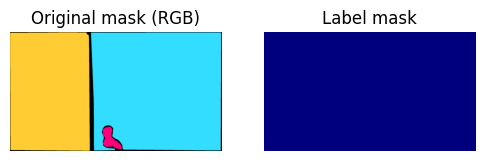

In [ ]:
# ---------- CELL 6 ----------
import numpy as np

# Replace these RGB tuples if your printed colors differ.
# From your PDF the unique colors were (approx): [0 0 0], [51 204 255], [124 0 255], [255 221 51]
# Format: (R,G,B)
color_map = {
    (0, 0, 0)        : 0,   # likely background
    (51, 204, 255)   : 1,
    (124, 0, 255)    : 2,
    (255, 221, 51)   : 3
}

def convert_color_mask_to_labels(mask_bgr, color_map):
    """
    mask_bgr: HxWx3 image read by cv2 (BGR order)
    color_map: dict mapping (R,G,B) -> label
    Returns HxW array of integer labels.
    """
    # convert to RGB (because color_map keys are RGB)
    mask_rgb = mask_bgr[:, :, ::-1]
    h, w = mask_rgb.shape[:2]
    label_mask = np.zeros((h, w), dtype=np.uint8)
    # For each color, set label where it matches
    for rgb, label in color_map.items():
        color_arr = np.array(rgb, dtype=np.uint8)[None, None, :]
        match = np.all(mask_rgb == color_arr, axis=-1)
        label_mask[match] = label
    return label_mask

# Test conversion on one sample mask (use the same sample you inspected)
sample_mask_path = train_pairs[0][1]
sample_mask = cv2.imread(sample_mask_path)  # BGR
label_mask = convert_color_mask_to_labels(sample_mask, color_map)
print("Converted sample mask shape:", label_mask.shape, "unique labels:", np.unique(label_mask))
# visualize quick (if in notebook)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(sample_mask[:,:,::-1].astype('uint8')); plt.title('Original mask (RGB)'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(label_mask, cmap='jet'); plt.title('Label mask'); plt.axis('off')
plt.show()


img: (256, 256, 3) min/max: 0.039215688 1.0 label shape: (256, 256) unique: [0]


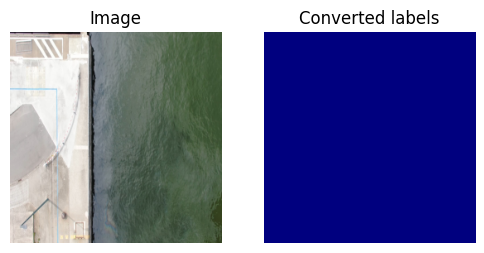

In [ ]:
# ---------- CELL 7 ----------
IMG_SIZE = (256,256)   # keep same as before

def preprocess(img_path, mask_path, size=IMG_SIZE, color_map=color_map):
    # read image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    img = img.astype('float32') / 255.0

    # read mask (BGR)
    mask_bgr = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    if mask_bgr is None:
        raise ValueError("Mask unreadable: "+mask_path)

    # If mask is color-coded (3 channels) convert to labels using color_map
    if mask_bgr.ndim == 3:
        mask_label = convert_color_mask_to_labels(mask_bgr, color_map)
    else:
        # single channel mask -> use directly
        mask_label = mask_bgr

    mask_label = cv2.resize(mask_label, size, interpolation=cv2.INTER_NEAREST)
    mask_label = mask_label.astype('int32')
    return img, mask_label

# Quick test again
img, lab = preprocess(train_pairs[0][0], train_pairs[0][1])
print("img:", img.shape, "min/max:", img.min(), img.max(), "label shape:", lab.shape, "unique:", np.unique(lab))
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(img); plt.axis('off'); plt.title('Image')
plt.subplot(1,2,2); plt.imshow(lab, cmap='jet'); plt.axis('off'); plt.title('Converted labels')
plt.show()


In [ ]:
# ---------- CELL 8 ----------
from tensorflow.keras.utils import Sequence
import random

class TestGen(Sequence):
    def __init__(self, pairs, batch_size=4):
        self.pairs = pairs
        self.batch_size = batch_size
    def __len__(self):
        return max(1, len(self.pairs)//self.batch_size)
    def __getitem__(self, idx):
        batch = self.pairs[idx*self.batch_size:(idx+1)*self.batch_size]
        X = []; Y = []
        for ip, mp in batch:
            x, y = preprocess(ip, mp)
            X.append(x); Y.append(y)
        X = np.array(X); Y = np.expand_dims(np.array(Y), -1)
        return X, Y

tg = TestGen(train_pairs[:8], batch_size=4)
X, Y = tg[0]
print("X shape:", X.shape, "Y shape:", Y.shape, "Y unique labels in batch:", np.unique(Y))


X shape: (4, 256, 256, 3) Y shape: (4, 256, 256, 1) Y unique labels in batch: [0]


In [ ]:
# ---------- CELL 9 ----------
class SegDataGenerator(Sequence):
    def __init__(self, pairs, batch_size=8, img_size=IMG_SIZE, shuffle=True, augment=False, color_map=color_map):
        self.pairs = pairs
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.color_map = color_map
        self.on_epoch_end()
    def __len__(self):
        return max(1, len(self.pairs)//self.batch_size)
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.pairs))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx*self.batch_size : (idx+1)*self.batch_size]
        imgs=[]; masks=[]
        for i in batch_indexes:
            img_path, mask_path = self.pairs[i]
            img, mask = preprocess(img_path, mask_path, self.img_size, color_map=self.color_map)
            if self.augment:
                # flip
                if random.random() < 0.5:
                    img = cv2.flip(img, 1)
                    mask = cv2.flip(mask, 1)
                # rotation by 90 degrees multiples
                if random.random() < 0.3:
                    k = random.choice([1,2,3])
                    img = np.rot90(img, k)
                    mask = np.rot90(mask, k)
            imgs.append(img)
            masks.append(mask)
        X = np.array(imgs, dtype='float32')
        y = np.expand_dims(np.array(masks, dtype='int32'), -1)
        return X, y

# instantiate
BATCH_SIZE = 8
train_gen = SegDataGenerator(train_pairs, batch_size=BATCH_SIZE, augment=True)
val_gen   = SegDataGenerator(val_pairs, batch_size=BATCH_SIZE, augment=False)
print("train_gen len (batches):", len(train_gen), "val_gen len:", len(val_gen))


train_gen len (batches): 101 val_gen len: 25


In [ ]:
# ---------- CELL 10 ----------
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

NUM_CLASSES = len(color_map)   # 4
def conv_block(inputs, filters):
    x = Conv2D(filters, 3, padding='same', activation='relu')(inputs)
    x = Conv2D(filters, 3, padding='same', activation='relu')(x)
    return x

def UNet(input_shape=(256,256,3), num_classes=NUM_CLASSES):
    inputs = Input(input_shape)
    c1 = conv_block(inputs, 64); p1 = MaxPooling2D()(c1)
    c2 = conv_block(p1, 128); p2 = MaxPooling2D()(c2)
    c3 = conv_block(p2, 256); p3 = MaxPooling2D()(c3)
    c4 = conv_block(p3, 512); p4 = MaxPooling2D()(c4)
    bn = conv_block(p4, 1024)
    u1 = UpSampling2D()(bn); u1 = Concatenate()([u1, c4]); c5 = conv_block(u1, 512)
    u2 = UpSampling2D()(c5); u2 = Concatenate()([u2, c3]); c6 = conv_block(u2, 256)
    u3 = UpSampling2D()(c6); u3 = Concatenate()([u3, c2]); c7 = conv_block(u3, 128)
    u4 = UpSampling2D()(c7); u4 = Concatenate()([u4, c1]); c8 = conv_block(u4, 64)
    outputs = Conv2D(num_classes, 1, activation='softmax')(c8)
    model = Model(inputs, outputs)
    return model

model = UNet()
model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]

 Total params: 31,379,140 (119.70 MB)

 Trainable params: 31,379,140 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ---------- CELL 11 ----------
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint('/content/best_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

EPOCHS = 20
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint, reduce_lr, early_stop]
)
# plot loss
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 69s/step - accuracy: 0.9457 - loss: 0.3160  